# Data Plots and preprocessing


In [1]:
### Basic Libraries
import pandas as pd
import os
import sys
from sklearn.preprocessing import MinMaxScaler

#Utils
from src import utils
from src import fc_utils
from src import plot_utils




#### Transcriptomics 

In [2]:
CCLE_expression = pd.read_csv('Data/CCLE/CCLE_expression.csv', index_col='Unnamed: 0')
CCLE_sample_info = pd.read_csv('Data/CCLE/sample_info.csv')

In [3]:
print(f"mRNA dimensions:{CCLE_expression.shape}\ninformation dimensions:{CCLE_sample_info.shape}")

mRNA dimensions:(1376, 19182)
information dimensions:(1812, 26)


In [4]:
# Create a dictionary mapping DepMap_ID to CCLE_Name
id_to_name_map = dict(zip(CCLE_sample_info['DepMap_ID'], CCLE_sample_info['CCLE_Name']))

# Rename indexes of ccle_transcriptomics using the id_to_name_map
CCLE_DepMap_ID = CCLE_expression.rename(index=id_to_name_map)
trascriptomics = CCLE_DepMap_ID.rename(columns=lambda x: str(x).split(' ')[0])
trascriptomics_processed = utils.process(trascriptomics)

Dimensions: (1376, 19182)


Counts Pipeline


In [5]:
counts_dict = dict()
for sample in trascriptomics.index:
    if '_' not in sample:
        continue
    name = sample.split('_', 1)[1]
    counts_dict[name] = counts_dict.get(name, 0) + 1
print(counts_dict)
total = 0
for _ , values in counts_dict.items():
    total+= values
print(total)

{'LUNG': 190, 'SOFT_TISSUE': 65, 'SKIN': 72, 'BILIARY_TRACT': 40, 'URINARY_TRACT': 36, 'LARGE_INTESTINE': 71, 'HAEMATOPOIETIC_AND_LYMPHOID_TISSUE': 212, 'ENDOMETRIUM': 37, 'STOMACH': 40, 'KIDNEY': 38, 'PANCREAS': 52, 'CENTRAL_NERVOUS_SYSTEM': 86, 'FIBROBLAST': 37, 'BREAST': 62, 'BONE': 40, 'UPPER_AERODIGESTIVE_TRACT': 51, 'OVARY': 65, 'CERVIX': 17, 'OESOPHAGUS': 32, 'LIVER': 25, 'AUTONOMIC_GANGLIA': 30, 'PLEURA': 17, 'PRIMARY': 1, 'UVEA': 7, 'TESTIS': 2, 'SKIN_FV1_RESISTANT': 2, 'THYROID': 18, 'PROSTATE': 12, 'SALIVARY_GLAND': 2, 'SKIN_CJ3_RESISTANT': 1, 'SMALL_INTESTINE': 1, 'SKIN_FV2_RESISTANT': 1, 'ENGINEERED': 6, 'SKIN_FV3_RESISTANT': 1, 'SKIN_CJ1_RESISTANT': 2, 'PLACENTA': 2, 'ADRENAL_CORTEX': 1, 'SKIN_CJ2_RESISTANT': 1}
1375


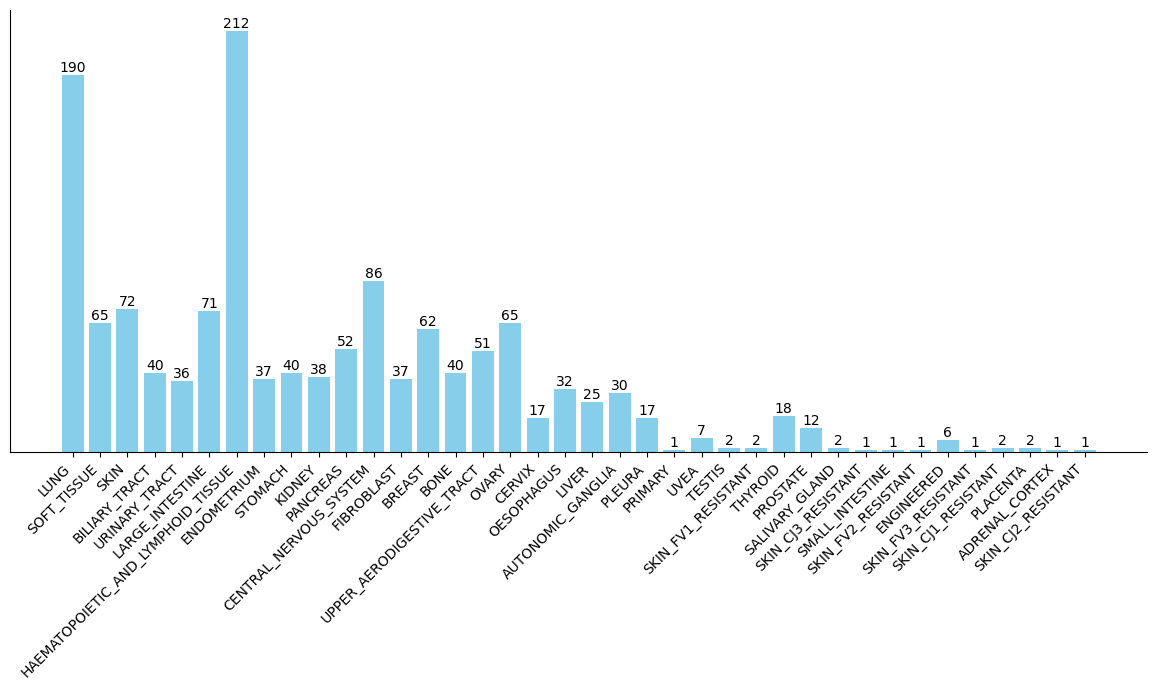

In [6]:
plot_utils.plot_counts_barchart(counts_dict)

#### Proteomics 

In [7]:
prot_normalized = pd.read_csv('Data\CCLE\Proteomics\protein_quant_current_normalized.csv', index_col=0)

In [8]:
prot_normalized.set_index('Gene_Symbol', inplace=True)
proteomics = prot_normalized.loc[:,  prot_normalized.columns.str.contains('_TenPx')]
proteomics.drop(columns=['SW948_LARGE_INTESTINE_TenPx11', 'CAL120_BREAST_TenPx02', 'HCT15_LARGE_INTESTINE_TenPx30'], 
                    inplace=True)
proteomics = proteomics.rename(columns = lambda x : str(x).split('_TenPx')[0])
proteomics_processed = utils.process(proteomics)

Dimensions: (7372, 375)


C:\Users\hp\AppData\Local\Temp\ipykernel_50296\2743761720.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  proteomics.drop(columns=['SW948_LARGE_INTESTINE_TenPx11', 'CAL120_BREAST_TenPx02', 'HCT15_LARGE_INTESTINE_TenPx30'],


In [9]:
ccle_transcr, ccle_prot= utils.match_proteins_samples(trascriptomics_processed.transpose(), proteomics_processed)

Number of common proteins: 6987
Number of common samples: 369


#### Comparisons

In [10]:
trascriptomics_processed = trascriptomics_processed.transpose()
proteomics_processed = proteomics_processed.transpose()

In [11]:
transcriptomics_processed = trascriptomics_processed[~trascriptomics_processed.index.duplicated(keep='first')]
proteomics_processed = proteomics_processed[~proteomics_processed.index.duplicated(keep='first')]
trascriptomics_processed.reset_index(drop=True, inplace=True)
proteomics_processed.reset_index(drop=True, inplace=True)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


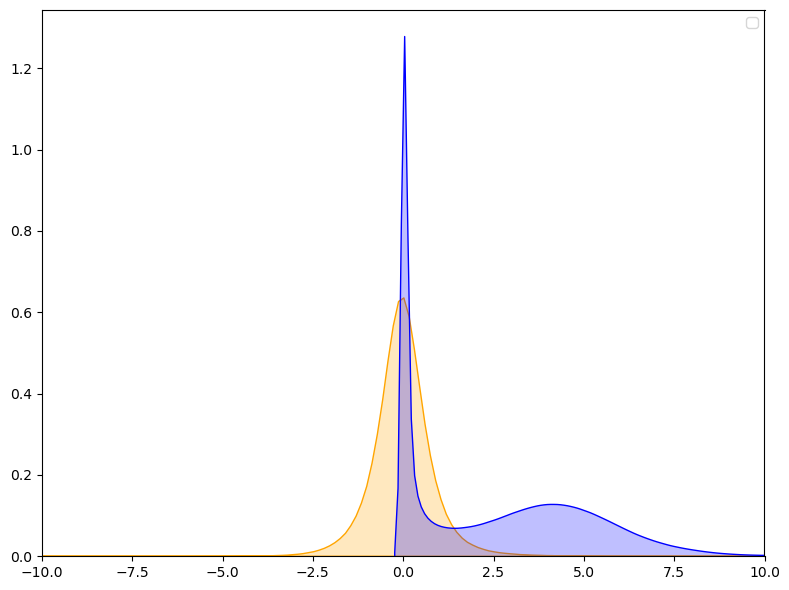

In [12]:
plot_utils.compare_datasets(trascriptomics_processed, proteomics_processed,limit = 10, name1 = 'Transcriptomics',name2= 'Proteomics')

#### Scaled

In [13]:
ccle_transcr = ccle_transcr.transpose()

In [14]:
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(ccle_transcr)
scaled_transcr = pd.DataFrame(scaled_data, columns=ccle_transcr.columns, index=ccle_transcr.index)

In [15]:
ccle_prot = ccle_prot.transpose()

In [16]:
scaled_data = scaler.fit_transform(ccle_prot)
scaled_prot = pd.DataFrame(scaled_data, columns=ccle_prot.columns, index=ccle_prot.index)
scaled_prot = scaled_prot.dropna(axis='columns', how='any')
ccle_prot = ccle_prot.dropna(axis='columns', how = 'any')
scaled_prot.shape

(369, 4843)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


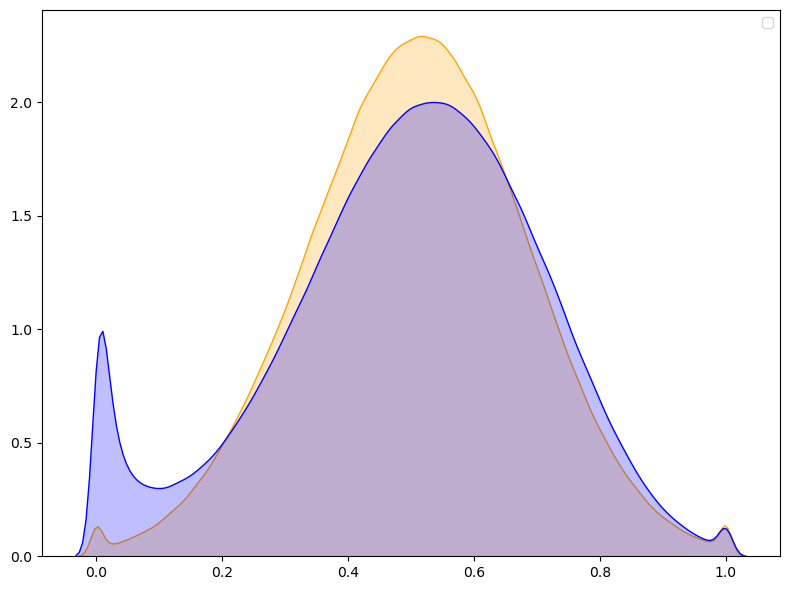

In [17]:
plot_utils.compare_datasets(scaled_transcr, scaled_prot, 'Transcriptomics', 'Proteomics')